In [2]:
#Loading the original tables into dataframes
#df_accident=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv', sep=',', header=0)
#df_vehicle=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1979-2021.csv', sep=',', header=0)
#df_casualty=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1979-2021.csv', sep=',', header=0)

In [370]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from python.data_cleaning import prepare_data_for_groupby
from python.grouped_data import data_for_analysis
from python import mlmodel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Filtering the dataframes to get dta from 1999 only
#df_accident_1999=df_accident[df_accident['accident_year']>=1999]
#df_vehicle_1999=df_vehicle[df_vehicle['accident_year']>=1999]
#df_casualty_1999=df_casualty[df_casualty['accident_year']>=1999]

In [3]:
#Exporting the data from 1999 as csv files --> the new raw data files
#df_accident_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv')
#df_vehicle_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1999-2021.csv')
#df_casualty_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1999-2021.csv')

In [4]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)
df_accidents.head()

/tmp/ipykernel_31702/1322138315.py:1: DtypeWarning: Columns (1,3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
4883216,1999010SU0945,1999,010SU0945,519490.0,203300.0,-0.271752,51.715661,1,3,1,...,0,1,4,1,0,0,2,1,1,E01023583
4883217,1999010SU0946,1999,010SU0946,521740.0,201070.0,-0.239977,51.695136,1,3,2,...,0,6,4,1,0,0,2,1,1,E01023584
4883218,1999010SU0947,1999,010SU0947,519610.0,203240.0,-0.270037,51.715096,1,3,2,...,0,4,1,2,0,0,2,1,1,E01023583
4883219,1999010SU0948,1999,010SU0948,520090.0,202830.0,-0.263233,51.711309,1,2,2,...,0,6,1,1,0,0,2,1,1,E01023583
4883220,1999010SU0949,1999,010SU0949,522640.0,200320.0,-0.227225,51.688200,1,3,4,...,0,1,1,2,0,0,2,1,1,E01023584


In [57]:
#Creating a small dataset to be loaded quickly
df_accidents_small=df_accidents[df_accidents['accident_year']==2019]
df_accidents_small.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-small.csv')

In [66]:
test=prepare_data_for_groupby(df_accidents,6)

In [67]:
test_data=data_for_analysis(test,granularity='W')
test_data.head(52)

,Accidents
date,
1998-12-29/1999-01-04,1586
1999-01-05/1999-01-11,4623
1999-01-12/1999-01-18,5000
1999-01-19/1999-01-25,4589
1999-01-26/1999-02-01,4137
1999-02-02/1999-02-08,3986
1999-02-09/1999-02-15,4320
1999-02-16/1999-02-22,3902
1999-02-23/1999-03-01,4321


In [68]:
test_data.shape

(1201, 1)

In [69]:
hashes=pd.DataFrame(test[['geohash','accident_year']].groupby('geohash').count())
hashes.columns=['Accidents']
hashes.sort_values('Accidents',inplace=True,ascending=False)
hashes.shape


(184578, 1)

In [70]:
hashes.describe()

,Accidents
count,184578.000000
mean,20.676852
std,57.175713
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,2045.000000


In [71]:
hashes[hashes['Accidents']>=100]

,Accidents
geohash,
gcpvj0,2045
gcpvhc,1959
gcpvj4,1871
gcpvj1,1816
gcpuv2,1744
...,...
gcwzyg,100
gcx6bn,100
u120gg,100


In [74]:
#Isolating the square where there are more accidents
max_square=hashes[hashes['Accidents']==hashes.Accidents.max()].index[0]
max_square

'gcpvj0'

In [206]:
#Filtering the data for the max_square
test_max_square=test[test['geohash']==max_square]
test_max_square.shape

(2045, 13)

In [81]:
test_data_max_square=data_for_analysis(test_max_square,'W')
test_data_max_square.head(50)

,Accidents
date,
1998-12-29/1999-01-04,1
1999-01-05/1999-01-11,1
1999-01-12/1999-01-18,1
1999-01-19/1999-01-25,1
1999-01-26/1999-02-01,1
1999-02-02/1999-02-08,4
1999-02-09/1999-02-15,3
1999-02-16/1999-02-22,5
1999-02-23/1999-03-01,2


In [405]:
FOLD_LENGTH=208 #each fold spans over 4 years
FOLD_STRIDE=52 #we have a  fold every 1 year
INPUT_LENGTH=10 #every X_i sequence is 10 weeks long
TRAIN_TEST_RATIO=.75 #in each fold, we use 3 years for training and 1 year for test
OUTPUT_LENGTH=10 #we want to predict the number of accidents in the next 10 weeks (y_i length)
SEQUENCE_STRIDE = 1

In [363]:
folds=mlmodel.get_folds(test_data_max_square,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(20, 208, 1)

In [227]:
fold1=folds[0]

In [364]:
(fold1_train, fold1_test) = mlmodel.train_test_split(fold1, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold1_train.shape

(156, 1)

In [365]:
X_train1, y_train1 = mlmodel.get_X_y_strides(fold1_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [233]:
X_train1.shape

(137, 10, 1)

In [366]:
X_test1, y_test1 = mlmodel.get_X_y_strides(fold1_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [367]:
X_test1.shape

(43, 10, 1)

In [392]:
model = mlmodel.init_model(X_train1)

In [393]:
model, history = mlmodel.fit_model(model,X_train1,y_train1)

Epoch 1/500
3/3 [==============================] - 8s 467ms/step - loss: 38.3534 - mae: 4.7245 - val_loss: 4.5149 - val_mae: 1.6485
Epoch 2/500
3/3 [==============================] - 0s 62ms/step - loss: 8.8439 - mae: 2.4134 - val_loss: 6.4490 - val_mae: 2.0592
Epoch 3/500
3/3 [==============================] - 0s 68ms/step - loss: 9.9110 - mae: 2.5950 - val_loss: 5.5680 - val_mae: 1.8771
Epoch 4/500
3/3 [==============================] - 0s 67ms/step - loss: 8.1429 - mae: 2.2420 - val_loss: 3.4712 - val_mae: 1.4402
Epoch 5/500
3/3 [==============================] - 0s 74ms/step - loss: 5.6752 - mae: 1.8324 - val_loss: 2.7386 - val_mae: 1.4107
Epoch 6/500
3/3 [==============================] - 0s 66ms/step - loss: 5.6508 - mae: 1.9204 - val_loss: 3.0621 - val_mae: 1.5078
Epoch 7/500
3/3 [==============================] - 0s 74ms/step - loss: 4.5250 - mae: 1.6619 - val_loss: 2.5873 - val_mae: 1.2858
Epoch 8/500
3/3 [==============================] - 0s 61ms/step - loss: 4.8379 - mae: 1.

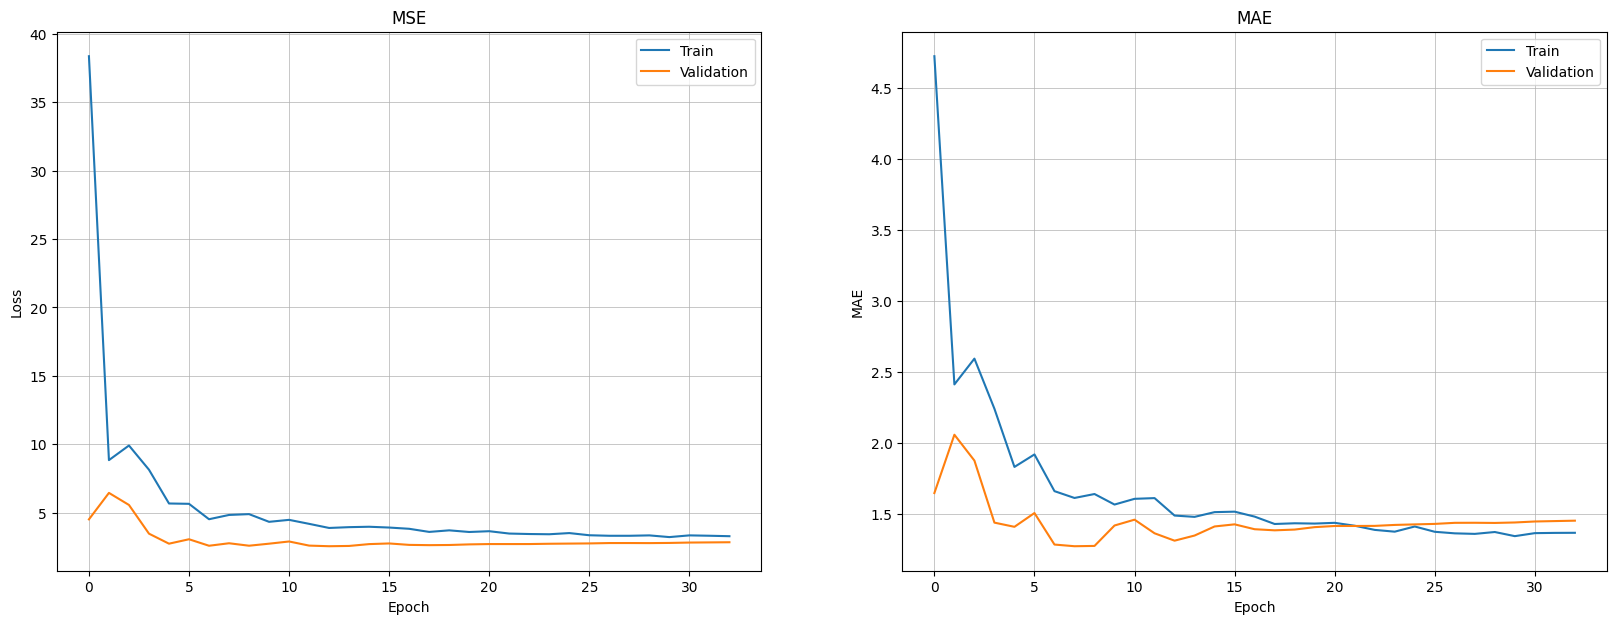

In [406]:
mlmodel.plot_history(history);

In [399]:
res=model.evaluate(X_test1,y_test1)

2/2 [==============================] - 0s 17ms/step - loss: 2.5247 - mae: 1.1832


In [183]:
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test1, y_test1)

2/2 [==============================] - 0s 7ms/step - loss: 4.1176 - mae: 1.8618


In [400]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 1.18 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 36.45 %


In [401]:
mae_baselines, mae_lstms = mlmodel.cross_validate_baseline_and_lstm(test_data_max_square,FOLD_LENGTH, FOLD_STRIDE,
                                     TRAIN_TEST_RATIO, INPUT_LENGTH,
                                     OUTPUT_LENGTH, SEQUENCE_STRIDE)

20
--------------------------------------------------
MAE baseline fold n°0 = 1.5
MAE LSTM fold n°0 = 1.1
Improvement over baseline: 26.57 % 

--------------------------------------------------
MAE baseline fold n°1 = 1.65
MAE LSTM fold n°1 = 1.06
Improvement over baseline: 35.85 % 

--------------------------------------------------
MAE baseline fold n°2 = 1.67
MAE LSTM fold n°2 = 1.0
Improvement over baseline: 40.07 % 

--------------------------------------------------
MAE baseline fold n°3 = 1.27
MAE LSTM fold n°3 = 0.99
Improvement over baseline: 21.79 % 

--------------------------------------------------
MAE baseline fold n°4 = 1.27
MAE LSTM fold n°4 = 0.89
Improvement over baseline: 29.67 % 

--------------------------------------------------
MAE baseline fold n°5 = 1.11
MAE LSTM fold n°5 = 0.85
Improvement over baseline: 23.78 % 

--------------------------------------------------
MAE baseline fold n°6 = 1.6
MAE LSTM fold n°6 = 1.07
Improvement over baseline: 33.08 % 

-------

In [402]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - np.array(mae_lstms)/np.array(mae_baselines)),2)*100}%")

➡ Average percentage improvement over baseline = 23.0%


In [403]:
np.mean(np.array(mae_lstms))

0.9914573758840561

In [404]:
np.mean(np.array(mae_baselines))

1.3159302294254303